In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import Household
from DataBase_wheels import small_updates
os.chdir(curr)
data_folder = os.getcwd()+'\\Data\\IO'
gams_folder = os.getcwd()+'\\gamsmodels\\HH'

The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb3.gdx is still active and was not deleted.


### *1: Read in data*

*Load IO data:*

In [2]:
GE_data = DataBase.GPM_database(pickle_path=data_folder+'\\GE_data')

*Load global settings:*

In [3]:
with open(data_folder+'\\Ex1_gs',"rb") as file:
    gs = pickle.load(file)

*Define settings for the module (simpler setup than production, as we only use one tree, i.e. no looping)*

In [4]:
name_module = 'HH' 
tree_name = 'HH_agg' 
file, sheet = 'HH.xlsx', 'nesting'

*Define partial equilibrium data, and general equilibrium data that are subsetted for the household sector:*

In [5]:
PE_data = ReadData.PE_from_GE(GE_data,GE_data.get('s_HH')[0])
GE_HH = small_updates.subset_db(GE_data.copy(),GE_data.get('s_HH'))

*read in nesting tree (similar to production, but a simpler setup):*

In [6]:
nt = nesting_tree.nesting_tree_hh(name=name_module,**{'version':'v1'}) # the version specifies calibration type.
nt.add_tree(data_folder+'\\'+file,tree_name=tree_name,**{'sheet':sheet}) # initialize tree
data = excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+file,{sheet:'vars'}) # read in data
DataBase.GPM_database.merge_dbs(nt.trees[tree_name].database, data ,'second') # add data
nt.run_all(PE_data,s0=GE_data.get('s_HH')[0],postfix='_'+name_module,int_temp = data['crra'].index) # add attributes

### *2: Static model:*

As in the production module, we start by setting up a static version of the model and calibrate this to the IO data. The steps are generally the same here as in the production module: (1) Initialize static model from nesting tree, (2) Add IO data to the model database, (3) solve and calibrate model.

*set up data and model:*

In [7]:
gm_static = Household.hh_static(nt=nt,work_folder=work_folder,gs_v=gs,**{'data_folder':work_folder,'name':'hh_static'})
DataBase.GPM_database.merge_dbs(gm_static.model.database,GE_HH,'second')

*slice IO data to only use exongeous data:*

In [8]:
gm_static.setstate('DC') # set state to 'dynamic calibration (DC), don't initialize settings
GE_HH_exo = gm_static.slice_exo(GE_HH,copy=True)

*calibrate (sneakily):*

In [9]:
gm_static.calibrate_sneaky(GE_HH_exo,kwargs_init={'check_variables':True},**{'n_steps':10})
db_static = gm_static.model_instances['baseline'].out_db

*Inspect solution compared to IO data:*

{'maxdiff': 0.0, 'plotdiff': None}


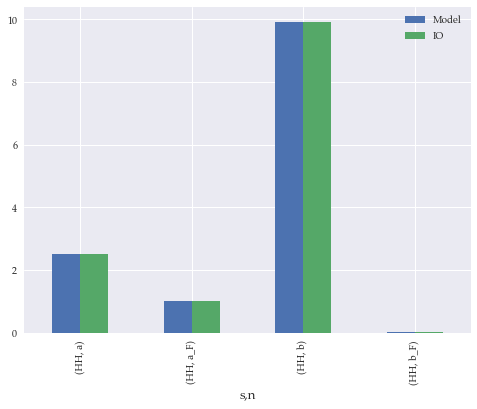

In [10]:
var,db = 'qD',gm_static.model_instances['baseline'].out_db
print(diagnostics.compare_data.std_diagnostics_var(db,GE_data,var,plot=False))
pd.DataFrame({'Model': diagnostics.compare_data.get_db1(db,GE_data,var), 'IO': diagnostics.compare_data.get_db2(db,GE_data,var)}).plot.bar(figsize=(8,6));

### *3: Dynamic model:*

The dynamic model is then based on the static one (as was the case w. the production module). Specifically we (1) initialize from the nesting tree, (2) add the savings subset, (3) initialize levels from the static model solution:

In [11]:
gm_hh = Household.hh_dynamic(nt=nt,work_folder=work_folder, gs_v = gs,**{'data_folder':gams_folder,'name':name_module})
gm_hh.add_svngs() # define subset of savings; call this element 'svngs' as default.
gm_hh.ivfs(db_static,merge=False) # initialize levels from static model
gm_hh.initialize_variables(**{'check_variables':True})
gm_hh.model.database[gm_hh.n('mu')].vals = db_static.get(gm_hh.n('mu')) # update calibrated parameters

Next, we add the baseline year to the IO data, slice the IO data to the values that are exogenous in the model and calibrate:

In [12]:
GE_HH_t = DataBase.GPM_database()
for var in GE_HH.variables_flat:
    GE_HH_t[var] = DataBase_wheels.repeat_variable_windex(GE_HH.get(var),gm_hh.get('t0'))
gm_hh.setstate('DC') # set state to 'dynamic calibration (DC)'
GE_HH_t = gm_hh.slice_exo(GE_HH_t,copy=False)
gm_hh.calibrate_sneaky(GE_HH_t,overwrite=True,**{'n_steps': 10,'diff':True})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*Store as pickle to run from at a later point:*

In [13]:
db = gm_hh.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_hh.model.database.symbols]; # delete symbols that are created only in order to calibrate model.
gm_hh.model.database.merge_dbs(gm_hh.model.database,db,'second')
gm_hh.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\HH\\gmspython_HH'

{'maxdiff': 1.0658141036401503e-14, 'plotdiff': None}


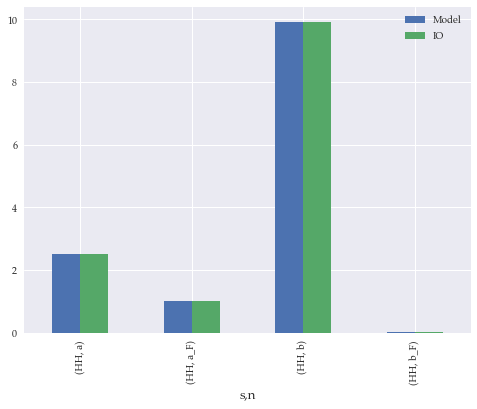

In [14]:
var,year,kwargs = 'qD',2, {'level':'t'}
print(diagnostics.compare_data.std_diagnostics_var(db,GE_data,var,xs=year,plot=False,**kwargs))
pd.DataFrame({'Model': diagnostics.compare_data.get_db1(db,GE_data,var,xs=year,**kwargs), 'IO': diagnostics.compare_data.get_db2(db,GE_data,var,xs=year,**kwargs)}).plot.bar(figsize=(8,6));